# Week 5 - Part 2- Assignment-Document Classification

## Team Members

*Simon Ustoyev

*Elina Azrilyan

*Jack Russo

*Anil Akyildirim

## Introduction

In this assignment, we are going to create a prediction model that we can classify whether or not a document or in this case SMS messages is ham (non-spam) or spam. 

## About the Data

For this assignment, we selected SMS Spam Collection dataset that is provided by UCI Machine Learning Repository which contains set of SMS messages in English of 5,574 messages, tagged according to being ham or spam. The original dataset and additional information on the dataset can be found here: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection 

[Assignment Video](https://screencast-o-matic.com/watch/cYilnP5s9r)

In [95]:
# Load required packages
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
import wordcloud
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

## Data Collection

The data is available in csv format so we can easily load to our notebook from our local machine. 

In [96]:
# load data
# drop the columns we dont need
# rename the columns so it makes more sense
df= pd.read_csv("spam.csv", encoding="latin-1")
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df = df.rename(columns={"v1":"label", "v2":"text"})
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Data Cleaning and Exploration
We loaded our data set, let's further look at some basic statisctics starting with the distribution of ham vs spam in the dataset.

In [97]:
df.groupby("label").describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

As expected majority of the text is ham (4825) rather than spam(747). Since we will be creating a classifier we need to convert the label which is our target variable to numerical.

In [98]:
df['spam'] = df['label'].map( {'spam': 1, 'ham': 0} ).astype(int)

In [99]:
# setting up values for ham or spam
df_ham  = df[df['spam'] == 0].copy()
df_spam = df[df['spam'] == 1].copy()

In [100]:
df.head()

,label,text,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


As part of exploration process, we can look at what words are used the most in each spam and ham SMS messages.

In [101]:
# create a function that can plot the wordcloud
def show_wordcloud(data, title):
    text = ' '.join(data['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS) # we need to set the stopwords
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(15,10), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

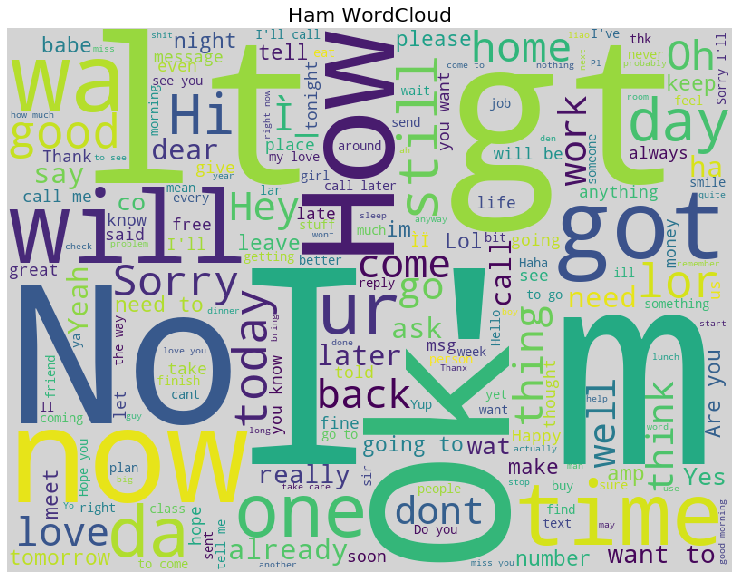

In [102]:
show_wordcloud(df_ham, "Ham WordCloud")

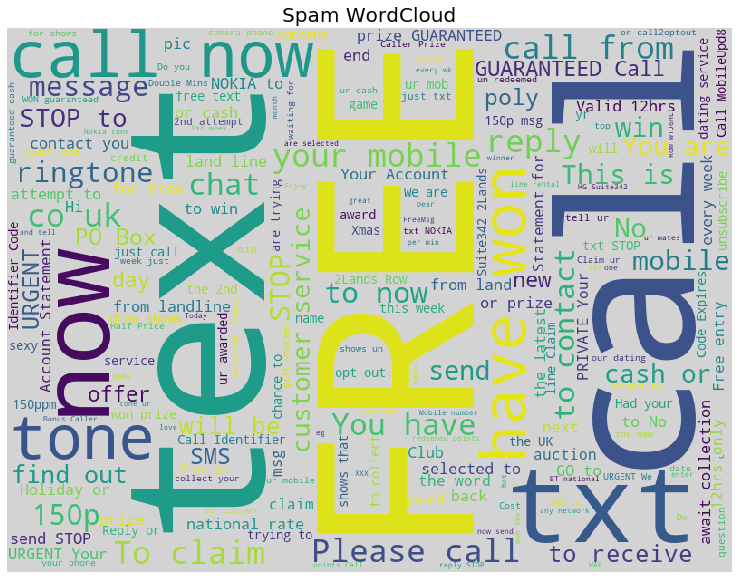

In [103]:
show_wordcloud(df_spam, "Spam WordCloud")

As we can see the word "Free" is used the spam SMS messages along with "call" and "call now"

In [104]:
# create a function to remove punctuation and stop words
def remove_punctuation_and_stopwords(sms):
    
    sms_no_punctuation = [ch for ch in sms if ch not in string.punctuation]
    sms_no_punctuation = "".join(sms_no_punctuation).split()
    
    sms_no_punctuation_no_stopwords = \
        [word.lower() for word in sms_no_punctuation if word.lower() not in stopwords.words("english")]
        
    return sms_no_punctuation_no_stopwords

In [105]:
# create the list of ham and spam words
df_ham.loc[:, 'text'] = df_ham['text'].apply(remove_punctuation_and_stopwords)
words_df_ham = df_ham['text'].tolist()
df_spam.loc[:, 'text'] = df_spam['text'].apply(remove_punctuation_and_stopwords)
words_df_spam = df_spam['text'].tolist()
list_ham_words = []
for sublist in words_df_ham:
    for item in sublist:
        list_ham_words.append(item)
list_spam_words = []
for sublist in words_df_spam:
    for item in sublist:
        list_spam_words.append(item)

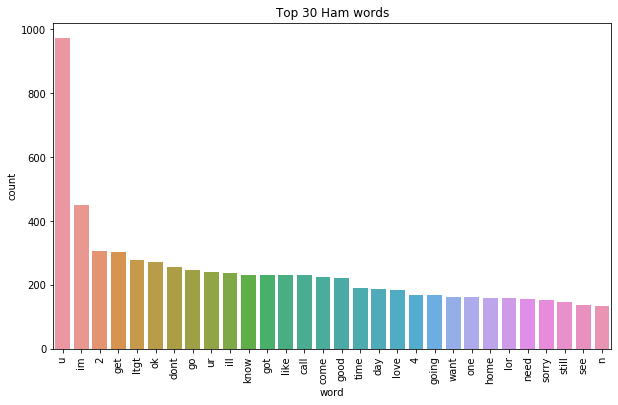

In [106]:
# frequency Dist
fdist_ham  = nltk.FreqDist(list_ham_words)
fdist_spam = nltk.FreqDist(list_spam_words)
# top 30 dataframe
df_hamwords_top30_nltk  = pd.DataFrame(fdist_ham.most_common(30),  columns=['word', 'count'])
df_spamwords_top30_nltk = pd.DataFrame(fdist_spam.most_common(30), columns=['word', 'count'])
# plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_hamwords_top30_nltk, ax=ax)
plt.title("Top 30 Ham words")
plt.xticks(rotation='vertical');

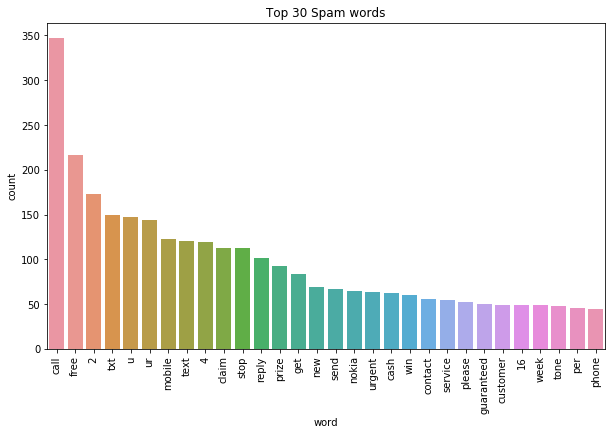

In [107]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_spamwords_top30_nltk, ax=ax)
plt.title("Top 30 Spam words")
plt.xticks(rotation='vertical');

When we look at the frequent words used in SMSs that are spam, we see "call", "free", "two" and "txt"

## Data Preprocessing

In terms of data preprocessing, we are going to follow the Bag of Words strategy in terms of tokenization, vectorization and normalization - TF-IDF). However first we will remoce the punctuations and stopwords from the text.

In [108]:
#remove punctuation and stop words
df['text'].apply(remove_punctuation_and_stopwords)
#remove_punctuation_and_stopwords(df['text'])

0       [go, jurong, point, crazy, available, bugis, n...
1                          [ok, lar, joking, wif, u, oni]
2       [free, entry, 2, wkly, comp, win, fa, cup, fin...
3           [u, dun, say, early, hor, u, c, already, say]
4       [nah, dont, think, goes, usf, lives, around, t...
                              ...                        
5567    [2nd, time, tried, 2, contact, u, u, å£750, po...
5568                   [ì, b, going, esplanade, fr, home]
5569                     [pity, mood, soany, suggestions]
5570    [guy, bitching, acted, like, id, interested, b...
5571                                   [rofl, true, name]
Name: text, Length: 5572, dtype: object

In [109]:
# create the bow for vectoriziation
bow_vectorizer = CountVectorizer(analyzer = remove_punctuation_and_stopwords).fit(df['text'])
# apply to the text messages and create a matrix
bow_matrix = bow_vectorizer.transform(df['text'])
bow_matrix

<5572x9431 sparse matrix of type '<class 'numpy.int64'>'
	with 49772 stored elements in Compressed Sparse Row format>

In [110]:
tfidf_transformer = TfidfTransformer().fit(bow_matrix)
tfidf_matrix = tfidf_transformer.transform(bow_matrix)
tfidf_matrix

<5572x9431 sparse matrix of type '<class 'numpy.float64'>'
	with 49772 stored elements in Compressed Sparse Row format>

## Model Development and Evaluation

We will further create two classification and model, run prediction and look at their accuracy.

In [111]:
# Train test and split
data_train, data_test, label_train, label_test = train_test_split(tfidf_matrix, df["spam"], test_size=0.3, random_state=5)
data_train

<3900x9431 sparse matrix of type '<class 'numpy.float64'>'
	with 35125 stored elements in Compressed Sparse Row format>

In [112]:
data_test

<1672x9431 sparse matrix of type '<class 'numpy.float64'>'
	with 14647 stored elements in Compressed Sparse Row format>

In [113]:
# Convert sparse matrix to matrix
data_train = data_train.A
data_test = data_test.A

In [114]:
# Naive Bayes Model
spam_detect_model = MultinomialNB().fit(data_train, label_train)
pred_test_MNB = spam_detect_model.predict(data_test)
acc_MNB = accuracy_score(label_test, pred_test_MNB)
print(acc_MNB)

0.965311004784689


In [115]:
# KNN
parameters_KNN = {'n_neighbors': (10,15,17), }

grid_KNN = GridSearchCV( KNeighborsClassifier(), parameters_KNN, cv=5,
                        n_jobs=-1, verbose=1)

grid_KNN.fit(data_train, label_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1, param_grid={'n_neighbors': (10, 15, 17)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [116]:
print(grid_KNN.best_params_)
print(grid_KNN.best_score_)

{'n_neighbors': 15}
0.9364102564102564


## Conclusion

We have creted two classification models using Naive Bayes and KNN. We can see the Naive Bayes model has better accuracy (96%) compare to KNN (93%). We can further explore to enhance these models possibly defining the optimal parameters for KNN or sclaing the TFIDF matrix and optimize the Naive Bayes Classifier.